In [2]:
import os
from os import path
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math
import autolens as al

from PIL import Image

import numpy as np
import pandas as pd
from torchvision.io import read_image

In [3]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', train=True, all=False, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if all:
            self.img_labels = df
        elif train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device = None):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

In [5]:
root = "__local/data/Cosmosim/11"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
training_data.img_labels

,name,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
0,j6japi.png,1.889527,0.633030,-0.204317,-0.175217,0.788429,0.272106,2.264476,0.562438,-0.681239,0.668825,0.022072,-0.018432,0.192617,4.130327
1,15s4gd.png,0.818295,0.464434,0.275639,-0.278350,-0.569483,0.283079,1.922834,0.937453,0.221420,0.003451,0.284899,0.137252,0.104605,3.477049
2,h89w4w.png,0.875939,0.441226,-0.369891,0.423763,-0.547342,0.428937,1.972183,0.355387,0.322400,0.473627,-0.147353,0.497139,0.302448,4.335599
3,gsvdem.png,1.476678,0.441246,0.344714,0.347564,-0.441701,0.016556,1.784205,0.417847,-0.026633,0.729169,0.335146,0.111218,0.121857,3.765161
4,ugt26f.png,1.700756,0.447054,-0.413193,0.040935,-0.668976,-0.735617,2.143647,0.604134,0.459667,-0.532237,-0.080711,0.251176,0.102956,4.160928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,cxc081.png,0.931616,0.604321,-0.240393,-0.392949,0.361409,0.384151,1.988496,0.189635,0.262043,-0.313192,-0.299189,-0.285023,0.697401,3.347303
159996,6f7lgm.png,1.546884,0.442018,-0.397447,-0.267752,-0.679493,-0.430861,1.801001,0.956174,0.051472,-0.232427,0.204232,0.066799,0.732343,3.057715
159997,3qp1jl.png,1.898330,0.575032,0.431895,0.279223,0.569810,0.010859,1.819464,0.796830,-0.147311,0.114917,0.101339,0.468808,0.438248,4.075768
159998,tftoyy.png,1.363200,0.496912,-0.217957,-0.458732,0.563897,0.330335,2.286099,0.173992,-0.338264,0.553582,0.109094,0.372031,0.370215,2.802243


In [7]:
test_data.img_labels

,name,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
160000,3i6yjz.png,0.832750,0.452046,0.399025,-0.186736,0.142335,-0.551321,2.145203,0.308320,-0.417885,-0.146697,0.028942,0.448936,0.717886,3.295939
160001,xv9sl5.png,1.081865,0.650985,-0.486514,0.474614,0.211407,0.086017,2.184456,0.652352,0.067939,-0.014560,0.434013,-0.328809,0.995187,2.893264
160002,kcr80o.png,1.426541,0.461895,-0.383181,-0.303669,-0.271193,-0.738875,1.593841,0.794000,-0.730677,-0.240439,-0.090581,-0.255273,0.970472,2.624371
160003,4vpbj7.png,1.149420,0.469218,-0.075768,-0.456172,-0.352900,-0.771105,1.915899,0.900731,-0.281811,-0.555527,-0.158678,0.138920,0.231181,4.322473
160004,00n66y.png,1.920325,0.489848,0.487189,0.457337,0.422741,0.360040,2.110427,0.453014,-0.261548,-0.558844,-0.075285,-0.345262,0.841666,4.621815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,anufnm.png,1.419900,0.547199,0.292524,0.291157,0.553388,-0.649478,1.573274,0.726753,0.789253,0.328867,0.278970,0.432017,0.884455,2.634884
199996,c7izyh.png,1.705961,0.647483,0.489194,-0.034840,-0.626730,0.163691,2.499470,0.288589,-0.284364,0.138865,0.372899,0.365795,0.371391,3.448709
199997,iwzdt2.png,0.953810,0.458328,0.308572,0.211359,0.284733,-0.258058,1.673660,0.624274,-0.027499,0.319222,-0.300318,0.354989,0.933837,4.201608
199998,v2xpr9.png,1.773667,0.667039,0.458885,-0.298446,0.662886,0.522802,1.990944,0.754726,-0.199482,-0.454747,0.328314,-0.004222,0.233591,4.807083


In [8]:
training_data.classes

['r_ein',
 'rdsf_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s',
 'si_s']

In [9]:
labels_map = training_data.img_labels.r_ein
labels_map

0         1.889527
1         0.818295
2         0.875939
3         1.476678
4         1.700756
            ...   
159995    0.931616
159996    1.546884
159997    1.898330
159998    1.363200
159999    0.813662
Name: r_ein, Length: 160000, dtype: float64

In [10]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([ 1.8895,  0.6330, -0.2043, -0.1752,  0.7884,  0.2721,  2.2645,  0.5624,
        -0.6812,  0.6688,  0.0221, -0.0184,  0.1926,  4.1303])


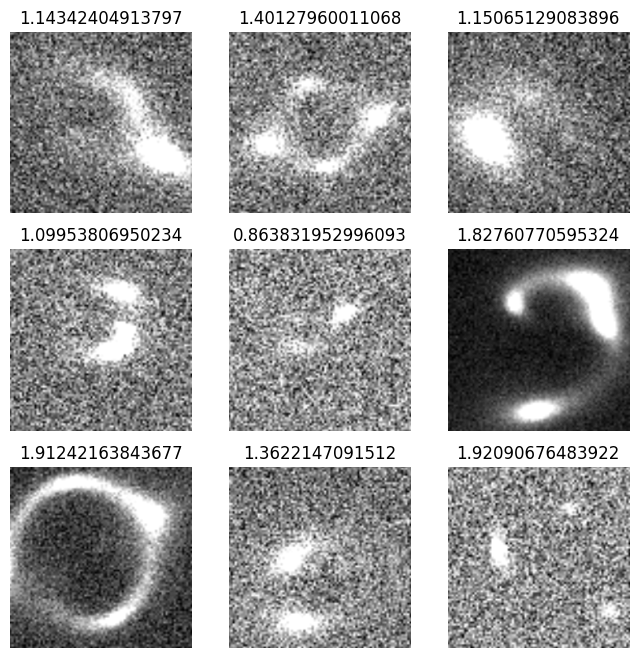

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 14])


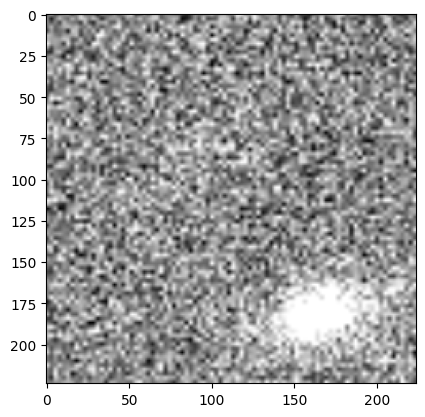

Label: tensor([ 1.5935,  0.6037,  0.0250, -0.4653,  0.5749,  0.5572,  1.7877,  0.5530,
        -0.6221,  0.5790,  0.0864,  0.3318,  0.3574,  3.0801])


In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [14]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=1, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [16]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
learning_rate = 1e-3
epochs = 10

In [18]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.835135  [   64/160000]
loss: 0.182305  [ 6464/160000]
loss: 0.151383  [12864/160000]
loss: 0.133849  [19264/160000]
loss: 0.133573  [25664/160000]
loss: 0.141097  [32064/160000]
loss: 0.147396  [38464/160000]
loss: 0.119623  [44864/160000]
loss: 0.126393  [51264/160000]
loss: 0.136150  [57664/160000]
loss: 0.147950  [64064/160000]
loss: 0.121643  [70464/160000]
loss: 0.108209  [76864/160000]
loss: 0.144068  [83264/160000]
loss: 0.115365  [89664/160000]
loss: 0.109785  [96064/160000]
loss: 0.120476  [102464/160000]
loss: 0.108638  [108864/160000]
loss: 0.100769  [115264/160000]
loss: 0.119531  [121664/160000]
loss: 0.105535  [128064/160000]
loss: 0.107237  [134464/160000]
loss: 0.090065  [140864/160000]
loss: 0.098217  [147264/160000]
loss: 0.100700  [153664/160000]
Test Error:
Avg loss: 0.090240 

Epoch 2
-------------------------------
loss: 0.090081  [   64/160000]
loss: 0.110641  [ 6464/160000]
loss: 0.102192  [12864/160000]
loss: 0.09

In [19]:
torch.save(model.state_dict(), '__local/models/model_alexnet_200k_slacs_less_params.pth')

### Evaluation

In [20]:
root = "__local/data/Cosmosim/test_slacs_4"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

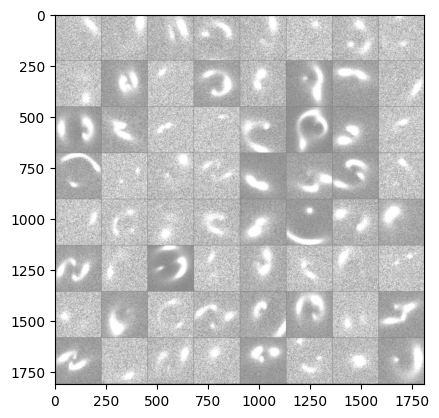

In [22]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [23]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=1, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [25]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
model_path = '__local/models/model_alexnet_200k_slacs_less_params.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
def evaluate(dataloader, model, loss_fn, device = 'cpu'):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    preds = torch.empty((0,len(training_data.classes)))
    reals = torch.empty((0,len(training_data.classes)))
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            preds = torch.cat((preds, pred))
            reals = torch.cat((reals, y))

    return pd.DataFrame(preds), pd.DataFrame(reals)

In [28]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [30]:
pd.DataFrame({'pred': preds.iloc[5], 'real': reals.iloc[1]})

,pred,real
0,1.848629,1.750149
1,0.561468,0.682648
2,-0.313301,0.019247
3,0.042676,0.441617
4,0.470980,0.559806
5,0.215883,0.327264
6,2.004616,2.013794
7,0.674909,0.674008
8,0.281885,0.621946
9,-0.600857,-0.517295


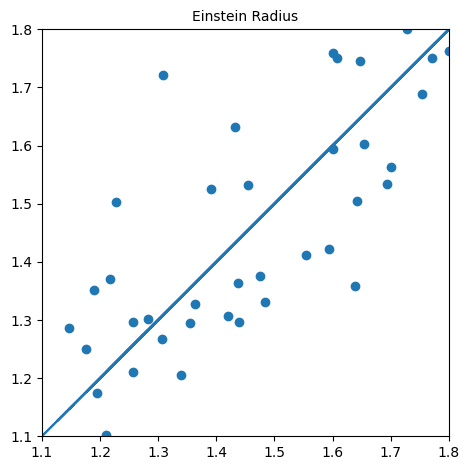

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x = preds[0][:32]
y = reals[0][:32]
a, b = np.polyfit(x, x, 1)

ax.scatter(preds[0][:64], reals[0][:64])
ax.plot(x, a*x+b)
ax.set_xlim(1.1, 1.8)
ax.set_ylim(1.1, 1.8)
ax.set_aspect('equal', 'box')
ax.set_title('Einstein Radius', fontsize=10)

fig.tight_layout()

plt.show()

In [32]:
root = "__local/data/Cosmosim/slacs/processed"
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

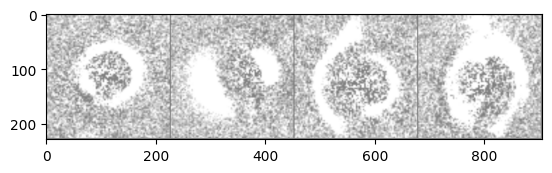

In [33]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [34]:
def simulate(grid, lens_galaxy, source_galaxy, simulator, shape=100):

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy, source_galaxy]
    )

    dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

    data = np.array(dataset.data)

    # Choose the lower and upper percentiles for normalization
    lower_percentile = 1
    upper_percentile = 95

    # Calculate the lower and upper limits for normalization
    lower_limit = np.percentile(data, lower_percentile)
    upper_limit = np.percentile(data, upper_percentile)

    # Clip and normalize the data to the 0-255 range
    normalized_data = np.clip(data, lower_limit, upper_limit)
    normalized_data = ((normalized_data - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)

    normalized_data = normalized_data.reshape(shape,shape)

    im = Image.fromarray(normalized_data).convert('L')
    # im = im.resize((400,400))

    return im

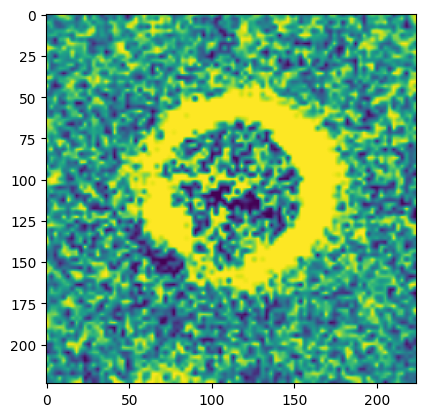

tensor([ 1.4971,  0.5614, -0.1037,  0.0571, -0.1147,  0.2459,  1.9543,  0.2889,
        -0.2158,  0.0462,  0.0304,  0.1531,  0.5750,  3.8687],
       grad_fn=<SelectBackward0>)
['r_ein', 'rdsf_l', 'x_l', 'y_l', 'ellx_l', 'elly_l', 'rdsf_s', 'r_eff_s', 'x_s', 'y_s', 'ellx_s', 'elly_s', 'int_s']


In [35]:
outputs = model(images)
i = 0
imshow(images[i])
print(outputs[i])
print(test_data.classes)

In [36]:
def model_paramaters(parameters):
    shape = 100
    scale = 0.05
    
    grid = al.Grid2D.uniform(
        shape_native=(shape, shape), 
        pixel_scales=scale
    )
    
    psf = al.Kernel2D.from_gaussian(
        shape_native=(21, 21), 
        sigma=0.1, 
        pixel_scales=grid.pixel_scales
    )
    
    simulator = al.SimulatorImaging(
        exposure_time=720.0, 
        psf=psf, 
        background_sky_level=800, 
        add_poisson_noise=True
    )
    
    lens = al.Galaxy(
        redshift=parameters.rdsf_l,
        mass=al.mp.Isothermal(
            centre=(parameters.x_l, parameters.y_l), einstein_radius=parameters.r_ein, ell_comps=(parameters.ellx_l, parameters.elly_l)
        ),
    )
    
    source = al.Galaxy(
        redshift=parameters.rdsf_s,
        bulge=al.lp.Sersic(
            centre=(parameters.x_s,parameters.y_s),
            ell_comps=(parameters.ellx_s, parameters.elly_s),
            intensity=parameters.int_s,
            effective_radius=parameters.r_eff_s,
            sersic_index=parameters.si_s,
        ),
    )

    return simulate(grid, lens, source, simulator, shape)

In [37]:
outputs = model(images)
outputs = outputs.detach().numpy()
parameters = pd.DataFrame(outputs, columns=training_data.classes)

In [38]:
parameters

,r_ein,rdsf_l,x_l,y_l,ellx_l,elly_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s,si_s
0,1.497070,0.561370,-0.103678,0.057111,-0.114722,0.245915,1.954297,0.288894,-0.215752,0.046249,0.030363,0.153057,0.575010,3.868664
1,1.973398,0.552190,-0.245024,0.158116,-0.024967,-0.243315,2.033741,0.495862,-0.187698,0.033619,-0.166687,0.106634,0.524973,3.586324
2,1.839186,0.544120,-0.364134,0.065015,-0.093491,-0.010865,1.926024,0.297585,-0.200206,-0.053192,-0.002464,-0.211385,0.645094,4.010958
3,1.751057,0.568274,-0.227012,0.191135,0.201259,0.124594,1.950311,0.420913,-0.246494,0.191899,0.022911,-0.290175,0.560174,3.945856


In [39]:
output_images = []
reconstructed_path = "__local/data/Cosmosim/slacs/processed/reconstructed"

for i in range(len(parameters.index)):
    im = model_paramaters(parameters.iloc[i])
    output_images.append(im)
    im.save(path.join(reconstructed_path, '{}.png'.format(i)))

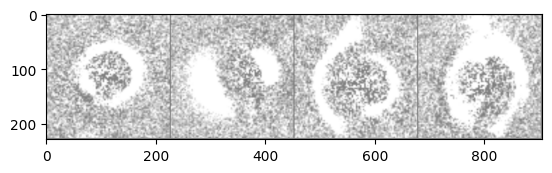

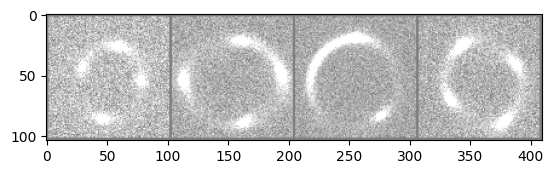

In [40]:
transform = transforms.Compose([transforms.ToTensor()])
out = [transform(x) for x in output_images]
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(out))